CNN training on CIFAR-10

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152
from models.efficientnet import efficientnet_b0, efficientnetv2_s

torch.manual_seed(0)

In [2]:
batch_size = 64
num_workers = 4

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = trainset.classes
num_classes = len(classes)
batches = len(trainloader)
step = batches // 10

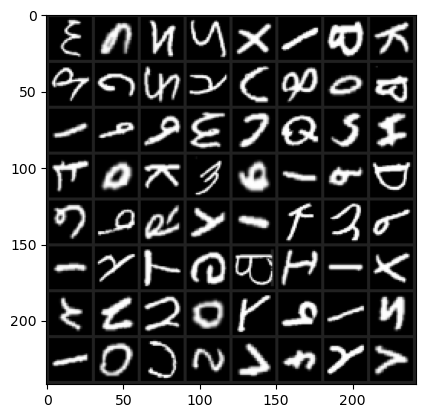

m e z z x i b k q c z y n g o b i d d m u q n h f o k w a l p d e d g y i k u p l y t g b i l x n n u o t d l z i o u s v t y v


In [3]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [4]:
device = 'cuda:0'
epochs = 10
lr = 1e-3

net = efficientnet_b0(size=28, in_channels=1, last_channels=1280, num_classes=num_classes, dropout=0.0)

net.to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

EfficientNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layers): Sequential(
    (0): Sequential(
      (0): MBConv(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (silu): SiLU(inplace=True)
        (se): SE(
          (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      )
    )
    (1): Sequential(
      (0): MBConv(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True,

In [5]:
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()
        total += labels.size(dim=0)
        
        if (i + 1) % step == 0:
            print(f'[Epoch {epoch + 1:02d}][Step {i + 1:04d}] Loss: {running_loss / (i + 1):.4f}, Accuracy: {correct / total:.4f}')

    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = net(images)

            correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()
            total += labels.size(dim=0)

    print(f'[Epoch {epoch + 1:02d}] Validation Accuracy: {correct / total:.4f} %')

RuntimeError: running_mean should contain 32 elements not 16

In [9]:
PATH = './model.pt'
torch.save(net.state_dict(), PATH)